In [0]:
# import getpass
# from oauth2client.client import GoogleCredentials
# from google.colab import auth
# !apt-get install - y - qq software-properties-common python-software-properties module-init-tools
# !add-apt-repository - y ppa: alessandro-strada/ppa 2 > &1 > /dev/null
# !apt-get update - qq 2 > &1 > /dev/null
# !apt-get - y install - qq google-drive-ocamlfuse fuse
# auth.authenticate_user()
# creds = GoogleCredentials.get_application_default()
# !google-drive-ocamlfuse - headless - id = {creds.client_id} - secret = {creds.client_secret} < /dev/null 2 > &1 | grep URL
# vcode = getpass.getpass()
# !echo {vcode} | google-drive-ocamlfuse - headless - id = {creds.client_id} - secret = {creds.client_secret}

E: Package 'python-software-properties' has no installation candidate


In [0]:
# !mkdir - p drive
# !google-drive-ocamlfuse drive - o nonempty

In [0]:
# import os
# os.chdir('drive')

In [0]:
# !ls Competitions/KDD-Cup-2019-CAMMTR/Data

ls: cannot access 'Competitions/KDD-Cup-2019-CAMMTR/Data': No such file or directory


In [1]:
import ast
from itertools import product

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import accuracy_score

import json
from tqdm import tqdm
import warnings
import numpy as np
import pandas as pd
import lightgbm as lgb
import os

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

warnings.filterwarnings("ignore")

# project_path='./Competitions/KDD-Cup-2019-CAMMTR/'
project_path = '../../'

holidays = pd.Series(
    json.load(open(project_path+r'Data/Holidays.json'))['holidays'])
subwayinfo = pd.read_csv(project_path+r'Data/BeijingSubway.csv')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# Feature engineering

In [2]:
def load_data(mainpath):
    train_queries = pd.read_csv(
        mainpath + 'train_queries.csv', parse_dates=['req_time'])
    train_plans = pd.read_csv(mainpath + 'train_plans.csv',
                              parse_dates=['plan_time'])
    train_clicks = pd.read_csv(mainpath + 'train_clicks.csv')
    profiles = pd.read_csv(mainpath + 'profiles.csv')
    test_queries = pd.read_csv(
        mainpath + 'test_queries.csv', parse_dates=['req_time'])
    test_plans = pd.read_csv(mainpath + 'test_plans.csv',
                             parse_dates=['plan_time'])
    return train_queries, train_plans, train_clicks, profiles, test_queries, test_plans

In [3]:
def merge(train_queries, train_plans, train_clicks, profiles, test_queries, test_plans):
    train = train_queries.merge(train_plans, 'left', ['sid'])
    test = test_queries.merge(test_plans, 'left', ['sid'])
    train = train.merge(train_clicks, 'left', ['sid'])
    train['click_mode'] = train['click_mode'].fillna(0).astype(int)
    data = pd.concat([train, test], ignore_index=True)
    data = data.merge(profiles, 'left', ['pid'])
    return train, test, data

In [4]:
def gen_plan_feas(data):
    n = data.shape[0]
    mode_list_feas = np.zeros((n, 12))
    max_dist, min_dist, mean_dist, std_dist = np.zeros(
        (n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))

    max_price, min_price, mean_price, std_price = np.zeros(
        (n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))

    max_eta, min_eta, mean_eta, std_eta = np.zeros(
        (n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))

    min_dist_mode, max_dist_mode, min_price_mode, max_price_mode, min_eta_mode, max_eta_mode, first_mode = \
        np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros(
            (n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))

    mode_texts = []
    for i, plan in tqdm(enumerate(data['plans_json'].values)):
        if len(plan) == 0:
            cur_plan_list = []
        else:
            cur_plan_list = plan
        if len(cur_plan_list) == 0:
            mode_list_feas[i, 0] = 1
            first_mode[i] = 0
            max_dist[i] = -1
            min_dist[i] = -1
            mean_dist[i] = -1
            std_dist[i] = -1
            max_price[i] = -1
            min_price[i] = -1
            mean_price[i] = -1
            std_price[i] = -1
            max_eta[i] = -1
            min_eta[i] = -1
            mean_eta[i] = -1
            std_eta[i] = -1
            min_dist_mode[i] = -1
            max_dist_mode[i] = -1
            min_price_mode[i] = -1
            max_price_mode[i] = -1
            min_eta_mode[i] = -1
            max_eta_mode[i] = -1
            mode_texts.append('word_null')
        else:
            distance_list = []
            price_list = []
            eta_list = []
            mode_list = []
            for tmp_dit in cur_plan_list:
                distance_list.append(int(tmp_dit['distance']))
                if tmp_dit['price'] == '':
                    price_list.append(0)
                else:
                    price_list.append(int(tmp_dit['price']))
                eta_list.append(int(tmp_dit['eta']))
                mode_list.append(int(tmp_dit['transport_mode']))
            mode_texts.append(
                ' '.join(['word_{}'.format(mode) for mode in mode_list]))
            distance_list = np.array(distance_list)
            price_list = np.array(price_list)
            eta_list = np.array(eta_list)
            mode_list = np.array(mode_list, dtype='int')
            mode_list_feas[i, mode_list] = 1
            distance_sort_idx = np.argsort(distance_list)
            price_sort_idx = np.argsort(price_list)
            eta_sort_idx = np.argsort(eta_list)
            max_dist[i] = distance_list[distance_sort_idx[-1]]
            min_dist[i] = distance_list[distance_sort_idx[0]]
            mean_dist[i] = np.mean(distance_list)
            std_dist[i] = np.std(distance_list)
            max_price[i] = price_list[price_sort_idx[-1]]
            min_price[i] = price_list[price_sort_idx[0]]
            mean_price[i] = np.mean(price_list)
            std_price[i] = np.std(price_list)
            max_eta[i] = eta_list[eta_sort_idx[-1]]
            min_eta[i] = eta_list[eta_sort_idx[0]]
            mean_eta[i] = np.mean(eta_list)
            std_eta[i] = np.std(eta_list)
            first_mode[i] = mode_list[0]
            max_dist_mode[i] = mode_list[distance_sort_idx[-1]]
            min_dist_mode[i] = mode_list[distance_sort_idx[0]]
            max_price_mode[i] = mode_list[price_sort_idx[-1]]
            min_price_mode[i] = mode_list[price_sort_idx[0]]
            max_eta_mode[i] = mode_list[eta_sort_idx[-1]]
            min_eta_mode[i] = mode_list[eta_sort_idx[0]]
    feature_data = pd.DataFrame(mode_list_feas)
    feature_data.columns = ['mode_feas_{}'.format(i) for i in range(12)]
    feature_data['max_dist'] = max_dist
    feature_data['min_dist'] = min_dist
    feature_data['mean_dist'] = mean_dist
    feature_data['std_dist'] = std_dist
    feature_data['max_price'] = max_price
    feature_data['min_price'] = min_price
    feature_data['mean_price'] = mean_price
    feature_data['std_price'] = std_price
    feature_data['max_eta'] = max_eta
    feature_data['min_eta'] = min_eta
    feature_data['mean_eta'] = mean_eta
    feature_data['std_eta'] = std_eta
    feature_data['max_dist_mode'] = max_dist_mode
    feature_data['min_dist_mode'] = min_dist_mode
    feature_data['max_price_mode'] = max_price_mode
    feature_data['min_price_mode'] = min_price_mode
    feature_data['max_eta_mode'] = max_eta_mode
    feature_data['min_eta_mode'] = min_eta_mode
    feature_data['first_mode'] = first_mode
    print('mode tfidf...')
    tfidf_enc = TfidfVectorizer(ngram_range=(1, 2))
    tfidf_vec = tfidf_enc.fit_transform(mode_texts)
    svd_enc = TruncatedSVD(n_components=10, n_iter=20, random_state=2019)
    mode_svd = svd_enc.fit_transform(tfidf_vec)
    mode_svd = pd.DataFrame(mode_svd)
    mode_svd.columns = ['svd_mode_{}'.format(i) for i in range(10)]
    plan_fea = pd.concat([feature_data, mode_svd], axis=1)
    plan_fea['sid'] = data['sid'].values

    return plan_fea

In [5]:
mainpath = project_path + r'Data/data_set_phase1/'

In [6]:
train_queries, train_plans, train_clicks, profiles, test_queries, test_plans = load_data(
    mainpath)

In [7]:
train, test, data = merge(train_queries, train_plans,
                          train_clicks, profiles, test_queries, test_plans)

In [8]:
def feature_engineering(df):
    df['time_diff'] = df['plan_time'].astype(
        int) - df['req_time'].astype(int)

    df['plans_json'] = data['plans'].fillna(
        '[]').apply(lambda x: json.loads(x))
    df_plans = gen_plan_feas(df)
    plan_features = [col for col in df_plans.columns if col not in ['sid']]
    df = df.merge(df_plans, on='sid', how='left')

    df['req_time'] = pd.to_datetime(df['req_time'])
    df['day_of_week'] = df['req_time'].dt.day_name()
    df['req_date'] = df['req_time'].dt.strftime('%m-%d')
    df['req_hour'] = df['req_time'].dt.hour
    df['req_minute'] = df['req_time'].dt.minute
    df['if_holiday'] = (df['req_date'].isin(holidays)).astype(int)

    # Week day
    current_c = list(df.columns.values)
    weekdays = ['Monday', 'Tuesday', 'Wednesday',
                'Thursday', 'Friday', 'Saturday', 'Sunday']
    current_c.extend(weekdays)
    df = df.reindex(columns=current_c, fill_value=0)
    for day_name in weekdays:
        df.loc[(df['day_of_week'] == day_name), [day_name]] = 1
    print('week day Done.')

    # Hour
    current_c = list(df.columns.values)
    oclock = [str(i)+'_oclock' for i in range(0, 24)]
    current_c.extend(oclock)
    df = df.reindex(columns=current_c, fill_value=0)
    for h in oclock:
        df.loc[(df['req_hour'] == int(h.split('_')[0])), [h]] = 1

    print('Hour Done.')

    df.drop(columns=['day_of_week', 'req_date', 'req_hour'], inplace=True)

    df['o_lng'] = df['o'].apply(lambda x: float(x.split(',')[0]))
    df['o_lat'] = df['o'].apply(lambda x: float(x.split(',')[1]))
    df['d_lng'] = df['d'].apply(lambda x: float(x.split(',')[0]))
    df['d_lat'] = df['d'].apply(lambda x: float(x.split(',')[1]))
    df['od_manhattan_distance'] = abs(
        df['o_lng']-df['d_lng'])+abs(df['o_lat']-df['d_lat'])

    print('OD distance done.')

    return df, weekdays, oclock, plan_features

In [9]:
data, weekdays, oclock, plan_features = feature_engineering(data)

594358it [01:35, 6227.89it/s]


mode tfidf...
week day Done.
Hour Done.
OD distance done.


# Reduce memory

In [10]:
def mem_usage(pandas_obj):
    if isinstance(pandas_obj, pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else:  # 我们假设这不是一个df，而是一个 Series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2  # 将 bytes 转化成 megabytes
    return "{:03.2f} MB".format(usage_mb)

In [11]:
data_float = data.select_dtypes(include=['float'])
converted_float = data_float.apply(pd.to_numeric, downcast='float')

print(mem_usage(data_float))
print(mem_usage(converted_float))

optimized_data = data.copy()

optimized_data[converted_float.columns] = converted_float

print(mem_usage(data))
print(mem_usage(optimized_data))
data = optimized_data

521.48 MB
263.01 MB
1068.29 MB
809.82 MB


# Add Centroid distance

In [16]:
o_co = data[['o']]
d_co = data[['d']]

o_co.columns=['co']
d_co.columns=['co']

all_co = pd.concat([d_co,o_co]).drop_duplicates()
all_co.shape

(6525, 1)

In [18]:
all_co['lng'] = all_co['co'].apply(lambda x: float(x.split(',')[0]))
all_co['lat'] = all_co['co'].apply(lambda x: float(x.split(',')[1]))

In [19]:
all_co.head()

,co,lng,lat
0,"116.32,39.96",116.32,39.96
1,"116.33,39.79",116.33,39.79
2,"116.27,40.00",116.27,40.00
3,"116.39,39.90",116.39,39.90
4,"116.37,39.86",116.37,39.86


# Add station distance feature

In [12]:
data['o_nearest_dis'] = np.nan
data['d_nearest_dis'] = np.nan

for co in tqdm(data['o'].unique()):
    lg, la = co.split(',')
    min_dis = (abs(subwayinfo['station_longitude']-float(lg)) +
               abs(subwayinfo['station_latitude']-float(la))).min()
    data.loc[(data['o'] == co), 'o_nearest_dis'] = min_dis


for co in tqdm(data['d'].unique()):
    lg, la = co.split(',')
    min_dis = (abs(subwayinfo['station_longitude']-float(lg)) +
               abs(subwayinfo['station_latitude']-float(la))).min()
    data.loc[(data['d'] == co), 'd_nearest_dis'] = min_dis

100%|██████████| 5101/5101 [03:19<00:00, 25.58it/s]


In [13]:
data.columns.values

array(['click_mode', 'click_time', 'd', 'o', 'pid', 'plan_time', 'plans',
       'req_time', 'sid', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7',
       'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17',
       'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26',
       'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35',
       'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44',
       'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53',
       'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62',
       'p63', 'p64', 'p65', 'time_diff', 'plans_json', 'mode_feas_0',
       'mode_feas_1', 'mode_feas_2', 'mode_feas_3', 'mode_feas_4',
       'mode_feas_5', 'mode_feas_6', 'mode_feas_7', 'mode_feas_8',
       'mode_feas_9', 'mode_feas_10', 'mode_feas_11', 'max_dist',
       'min_dist', 'mean_dist', 'std_dist', 'max_price', 'min_price',
       'mean_price', 'std_price', 'max_eta', 'min_eta', 'mean_eta',
       'std_eta', '

In [31]:
profile_feature = ['p' + str(i) for i in range(66)]
origin_num_feature = ['o_lng', 'o_lat', 'd_lng', 'd_lat',
                      'od_manhattan_distance', 'o_nearest_dis', 'd_nearest_dis'] + profile_feature
cate_feature = ['pid']
time_feature = weekdays + oclock + ['if_holiday']
feature = origin_num_feature + plan_features + time_feature+cate_feature
print('Got %s features' % str(len(feature)))

Got 147 features


# Fill nan

In [15]:
# for p in profile_feature:
#     data[p].fillna(data[p].mode()[0], inplace=True)

# Data split

In [32]:
train_index = (data.req_time < '2018-11-23')
train_x = data[train_index][feature].reset_index(drop=True)
train_y = data[train_index].click_mode.reset_index(drop=True)

valid_index = (data.req_time > '2018-11-23') & (data.req_time < '2018-12-01')
valid_x = data[valid_index][feature].reset_index(drop=True)
valid_y = data[valid_index].click_mode.reset_index(drop=True)

test_index = (data.req_time > '2018-12-01')
test_x = data[test_index][feature].reset_index(drop=True)

# Train

In [17]:
def f1_weighted(labels, preds):
    preds = np.argmax(preds.reshape(12, -1), axis=0)
    score = f1_score(y_true=labels, y_pred=preds, average='weighted')
    return 'f1_weighted', score, True

In [33]:
lgb_model = lgb.LGBMClassifier(boosting_type="gbdt",
                               num_leaves=61,
                               reg_alpha=0,
                               reg_lambda=0.01,
                               max_depth=-1,
                               n_estimators=2000,
                               objective='multiclass',
                               subsample=0.8,
                               colsample_bytree=0.8,
                               subsample_freq=1,
                               min_child_samples=50,
                               learning_rate=0.05,
                               random_state=2019,
                               metric="None",
                               n_jobs=-1)

In [34]:
eval_set = [(valid_x, valid_y)]
lgb_model.fit(train_x, train_y, eval_set=eval_set, eval_metric=f1_weighted,
              categorical_feature=cate_feature, verbose=10, early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds.
[10]	valid_0's f1_weighted: 0.627979
[20]	valid_0's f1_weighted: 0.675342
[30]	valid_0's f1_weighted: 0.682087
[40]	valid_0's f1_weighted: 0.683813
[50]	valid_0's f1_weighted: 0.684914
[60]	valid_0's f1_weighted: 0.685669
[70]	valid_0's f1_weighted: 0.685968
[80]	valid_0's f1_weighted: 0.68633
[90]	valid_0's f1_weighted: 0.68679
[100]	valid_0's f1_weighted: 0.687192
[110]	valid_0's f1_weighted: 0.68769
[120]	valid_0's f1_weighted: 0.687683
[130]	valid_0's f1_weighted: 0.687656
[140]	valid_0's f1_weighted: 0.687713
[150]	valid_0's f1_weighted: 0.687599
[160]	valid_0's f1_weighted: 0.687501
[170]	valid_0's f1_weighted: 0.687622
[180]	valid_0's f1_weighted: 0.687743
[190]	valid_0's f1_weighted: 0.687902
[200]	valid_0's f1_weighted: 0.687801
[210]	valid_0's f1_weighted: 0.687455
[220]	valid_0's f1_weighted: 0.687585
[230]	valid_0's f1_weighted: 0.687412
[240]	valid_0's f1_weighted: 0.687305
[250]	valid_0's f1_weighted: 0.687271

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
        importance_type='split', learning_rate=0.05, max_depth=-1,
        metric='None', min_child_samples=50, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=2000, n_jobs=-1, num_leaves=61,
        objective='multiclass', random_state=2019, reg_alpha=0,
        reg_lambda=0.01, silent=True, subsample=0.8,
        subsample_for_bin=200000, subsample_freq=1)

# Feature importance

In [35]:
imp = pd.DataFrame()
imp['features'] = feature
imp['importance'] = lgb_model.feature_importances_
imp = imp.sort_values('importance', ascending=False)
imp

,features,importance
146,pid,33207
5,o_nearest_dis,4849
96,std_eta,4729
6,d_nearest_dis,4318
88,std_dist,4085
0,o_lng,3601
1,o_lat,3477
2,d_lng,3469
94,min_eta,3341
106,svd_mode_2,3236


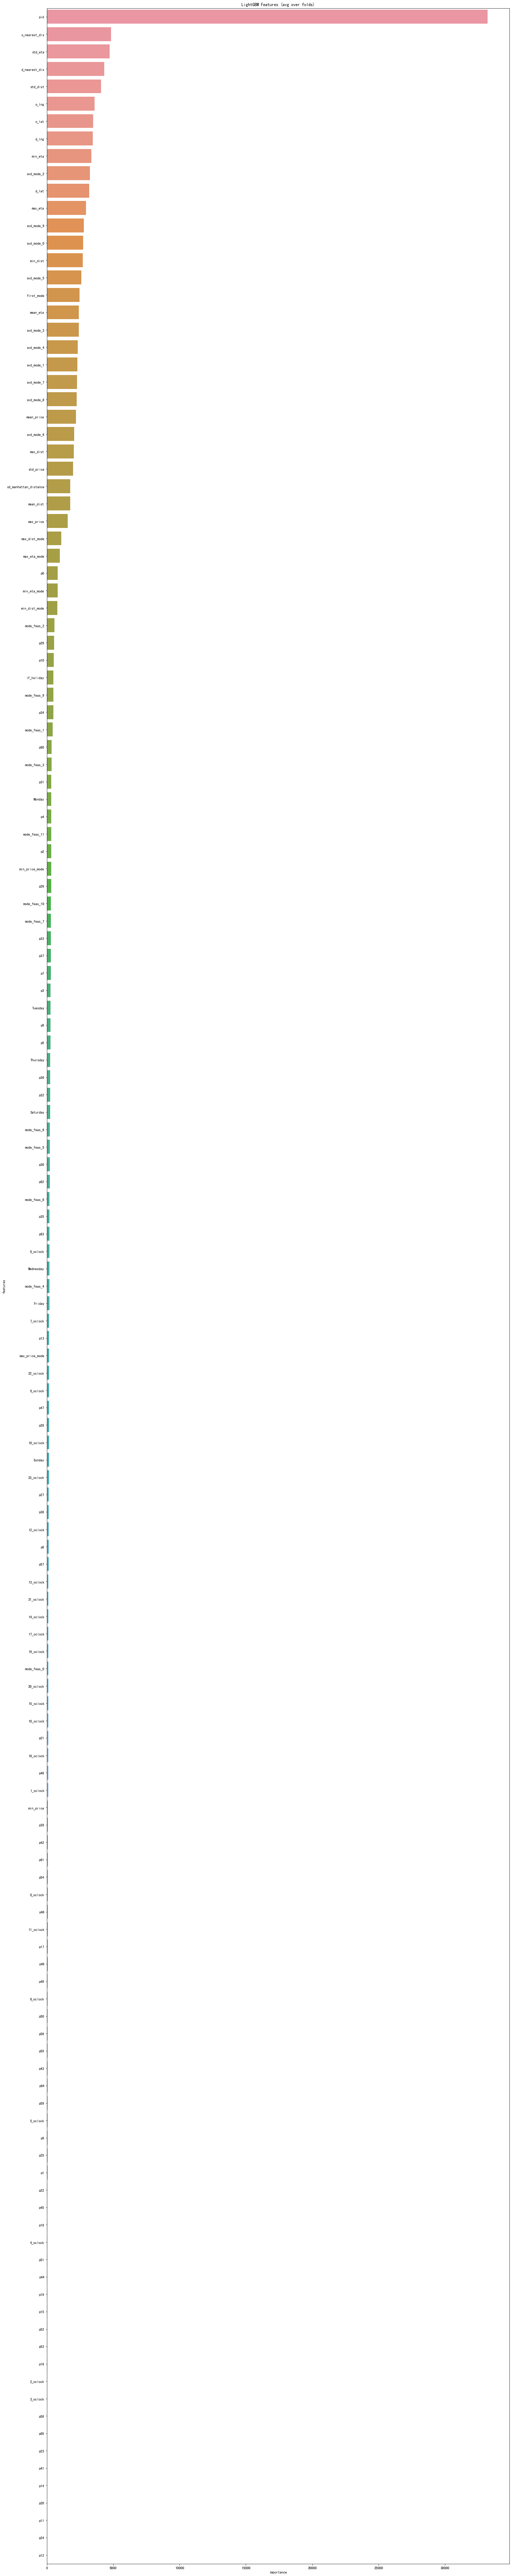

In [36]:
plt.figure(figsize=(20, 100))
sns.barplot(x="importance",
            y="features",
            data=imp)
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

# Predict

In [42]:
pred = lgb_model.predict(valid_x)
df_analysis = pd.DataFrame()
df_analysis['sid'] = data[valid_index]['sid']
df_analysis['label'] = valid_y.values
df_analysis['pred'] = pred
df_analysis['label'] = df_analysis['label'].astype(int)
dic_ = df_analysis['label'].value_counts(normalize=True)

score_df = pd.DataFrame(
    columns=['class_id', 'counts*f1_score','f1_score', 'precision', 'recall'])


def get_weighted_fscore(y_pred, y_true):
    f_score = 0
    for i in range(12):
        yt = y_true == i
        yp = y_pred == i
        f_score += dic_[i] * f1_score(y_true=yt, y_pred=yp)
        score_df.loc[i] = [i, dic_[i], f1_score(y_true=yt, y_pred=yp), precision_score(
            y_true=yt, y_pred=yp), recall_score(y_true=yt, y_pred=yp)]
    print(f_score)
    return score_df


score_df = get_weighted_fscore(
    y_true=df_analysis['label'], y_pred=df_analysis['pred'])
score_df

0.7095882458513125


,class_id,counts*f1_score,f1_score,precision,recall
0,0.0,0.087414,0.366483,0.931466,0.228118
1,1.0,0.144617,0.706743,0.639357,0.790008
2,2.0,0.313324,0.905709,0.854343,0.963647
3,3.0,0.044598,0.154035,0.581019,0.088787
4,4.0,0.024453,0.066626,0.760563,0.034839
5,5.0,0.097574,0.850544,0.784407,0.928860
6,6.0,0.019893,0.250435,0.465517,0.171293
7,7.0,0.177920,0.800391,0.716327,0.906810
8,8.0,0.004559,0.771171,0.804511,0.740484
9,9.0,0.049931,0.555919,0.611448,0.509637


In [43]:
score_df['counts*f1_score'].sum()

1.0

In [38]:
all_train_x = data[data.req_time <
                   '2018-12-01'][feature].reset_index(drop=True)
all_train_y = data[data.req_time <
                   '2018-12-01'].click_mode.reset_index(drop=True)
print(lgb_model.best_iteration_)
lgb_model.n_estimators = lgb_model.best_iteration_
lgb_model.fit(all_train_x, all_train_y, categorical_feature=cate_feature)
print('fit over')
result = pd.DataFrame()
result['sid'] = data[test_index]['sid']
result['recommend_mode'] = lgb_model.predict(test_x)
result['recommend_mode'] = result['recommend_mode'].astype(int)
print(len(result))
print(result['recommend_mode'].value_counts())

191
fit over
94358
2     34118
7     22334
1     17817
5     10874
10     3413
0      2115
9      1981
3       512
6       404
11      384
8       330
4        76
Name: recommend_mode, dtype: int64


In [39]:
result[['sid', 'recommend_mode']].to_csv(
    project_path + 'Data/long_legs.csv', index=False)